# Degree-heterogeneous Latent Class Model

DH-LCA (Degree-heterogeneous Latent Class Analysis) is a new model proposed by Lyu et al. It addresses the challenges associated with quantitative heterogeneity in high-dimensional clustering of binary data by leveraging a spectral approach (HeteroClustering) to decompose the data. Their test results show that,  under certain conditions maintaining the ratio of signal to noise in the data, HeteroClustering within DhLCMs can accurately identify clusters as compared to traditional methods.


To check the value of $\omega_i$ in the context of binary data collected in a DhLCM, where each subject $i$ is endowed with a continuous degree parameter $\omega_i > 0$, we consider the conditional probability of observing a positive response to feature $j$ by a subject from latent class $k$ with degree one $\omega_i = 1$.

The conditional probability $P(R_{i,j} = 1 | s_i = k)$ is given by:

$$P(R_{i,j} = 1 | s_i = k) = \omega_i \theta_{j,k}$$

Where:
- $R_{i,j}$ is the observation of subject $i$ on feature $j$.
- $s_i$ represents the latent class membership of subject $i$.
- $\theta_{j,k}$ represents the conditional probability of observing a positive response to feature $j$ by a subject from latent class $k$ with degree one $\omega_i = 1$.

The steps to implement HeteroClustering algorithm are:
1. Apply HeteroPCA (Zhang et al., 2022) to data matrix to extract top left singular vectors.
2. Normalize principal components using ℓ2 normalization to remove degree effects.
3. Perform K-means clustering on normalized row vectors.
4. Estimate parameters



The following technical assumptions are introduced:
1. **Assumption 1 (Balanced cluster sizes):** There exists an absolute constant $\beta \in (0, 1)$ such that $\max_{k \in [K]} |C_k| \leq \beta \min_{k \in [K]} |C_k|$. In other words, each cluster size is balanced across all data points.

2. **Assumption 2 (Constant degrees):** There exist absolute constants $c_0, C_0 > 0$ such that $c_0 < \min_{i \in [N]} \omega_i \leq \max_{i \in [N]} \omega_i < C_0$ or in other words, (a) all degree parameters $\omega_i$'s are of the same order, and (b) the order is constant.

This notebook attempts to replicate this model on a Kaggle dataset called 'Patient Risk Profiles' (https://www.kaggle.com/datasets/sujaykapadnis/patient-risk-profiles). The dataset contains binary responses on multiple risk factor for each patient profile (dim: 100x100). 

The aim is to classify patients who had heart failure in the previous year based on the given risk factors. The dataset as resampled to satisfy Assimption (1) above, and continuous predictors were removed. Final dataset size: 46 x 84

**This document is an initial attempt and is currently under development. Results presented here should not be interpreted as indicative of a successful implementation of DH-LCM.**

## Load dependencies

In [45]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_palette("pastel")

import missingno as msno
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.linalg import sqrtm
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## Load and prepare data

In [ ]:
df = pd.read_csv("patient_risk_profiles.csv")

In [ ]:
# Drop continuous variables
df = df.drop(columns=['predicted risk of Pulmonary Embolism', 'predicted risk of Sudden Hearing Loss, No congenital anomaly or middle or inner ear conditions',
 'predicted risk of Restless Leg Syndrome',
 'predicted risk of Sudden Vision Loss, with no eye pathology causes',
 'predicted risk of Muscle weakness or injury',
 'predicted risk of Ankylosing Spondylitis',
 'predicted risk of Autoimmune hepatitis',
 'predicted risk of Multiple Sclerosis',
 'predicted risk of Acute pancreatitis, with No chronic or hereditary or common causes of pancreatitis',
 'predicted risk of Ulcerative colitis',
 'predicted risk of Migraine',
 'predicted risk of Dementia',
 'predicted risk of  Treatment resistant depression (TRD)',
 "predicted risk of Parkinson's disease, inpatient or with 2nd diagnosis"])

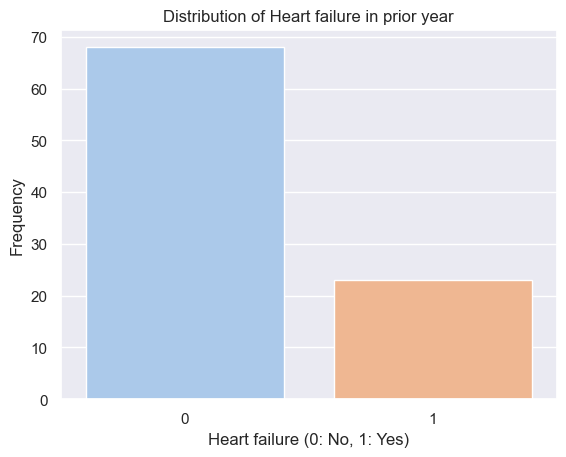

In [63]:
# Check class distribution of main variable (`Heart failure in prior year`)
sns.countplot(data=df, x='Heart failure in prior year')
plt.title('Distribution of Heart failure in prior year')
plt.xlabel('Heart failure (0: No, 1: Yes)')
plt.ylabel('Frequency')
plt.show()

In [64]:
# Extract data matrix R (N xJ) from df and undersample the data to ensure balanced classes

In [65]:
df_X = df.drop(columns=['Heart failure in prior year','personId'])
df_Y = df['Heart failure in prior year'].astype(int)

In [66]:
print('Original dataset shape %s' % Counter(df_Y))

Original dataset shape Counter({0: 68, 1: 23})


In [67]:
rus = RandomUnderSampler(random_state=1313)
df_X_rus, df_Y_rus =rus.fit_resample(df_X, df_Y)

In [68]:
print('Resampled dataset shape %s' % Counter(df_Y_rus))

Resampled dataset shape Counter({0: 23, 1: 23})


## HeteroClustering Algorithm

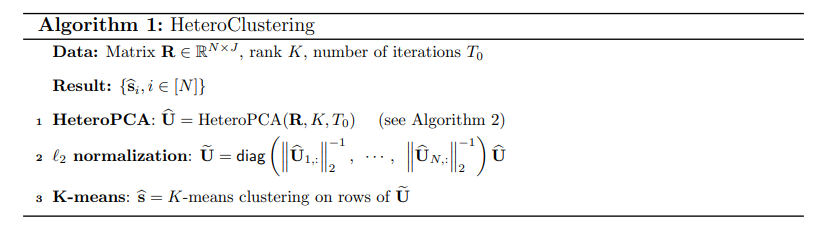

Source: Lyu, Z., Chen, L., & Gu, Y. (2024). Degree-heterogeneous Latent Class Analysis for High-dimensional Discrete Data. arXiv preprint arXiv:2402.18745.

In [82]:
def hetero_clustering(df_X_rus, K,T0):
    R = df_X_rus.to_numpy()
    
    # Apply HeteroPCA
    U_hat = hetero_pca(R, K, T0)
    
    # Apply L2 normalization
    U_tilda = np.diag(1/np.linalg.norm(U_hat, axis=1)) @ U_hat
    
    # K means using sci-kit learn
    kmeans = KMeans(n_clusters=K, random_state=1313)
    
    # Estimate parameters
    bs = kmeans.fit_predict(U_tilda)
    Theta = estimate_theta(R, bs, K)
    
    return bs, Theta

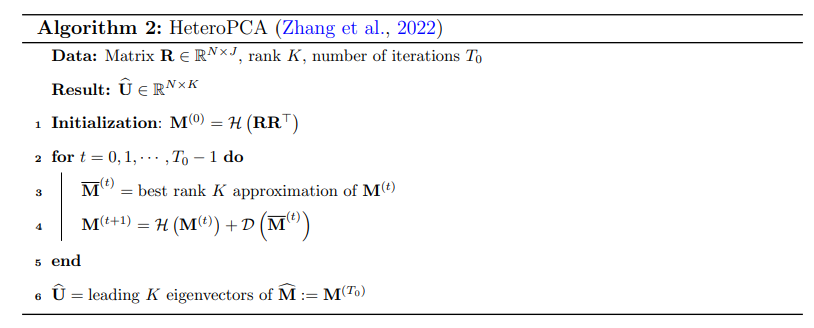

Source: Lyu, Z., Chen, L., & Gu, Y. (2024). Degree-heterogeneous Latent Class Analysis for High-dimensional Discrete Data. arXiv preprint arXiv:2402.18745.

In [83]:
def hetero_pca(R, K, T0):
    M = R @ R.T
    # Manual iterations to optimize; WIP (this may not be accurate)
    for _ in range(T0):
        U, s, Vh = np.linalg.svd(M, full_matrices=False)
        M = np.dot(U[:,:K], np.dot(np.diag(s[:K]), Vh[:K, :]))  
        
        M = 0.5 * (M + M.T)

    U = np.linalg.eigh(M)[1][:, ::-1][:, :K]
    return U

**Note:** The paper estimates parameters by averaging the samples belonging to the same estimated latent class, **after correcting the degree effect**. The following code will be edited to correct degree effects in next iteration of this code. Please ignore parameter estimates for now.

In [84]:
def estimate_theta(R, labels, K):
    # Calculates parameters as centroid of each cluster as the average of the samples belonging to that cluster
    Theta = np.zeros((R.shape[1], K))
    
    for k in range(K):
        cluster_samples = R[labels == k]
        avg_sample = np.mean(cluster_samples, axis=0)
        Theta[:, k] = avg_sample
    
    return Theta

## Apply on the dataset

In [ ]:
# Define no. of clusters (Had a heart faiure vs did not have a heart failure i.e., 2) and no. of iterations for HeteroPCA
K = 2 
T0 = 100  


cluster_assignments, cluster_parameters = hetero_clustering(df_X_rus, K, T0) # cluster_parameters are NOT accurate at this stage

Cluster Assignments: [1 1 1 0 1 1 1 1 0 0 1 1 0 1 0 1 1 1 0 0 0 1 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1
 0 0 1 0 1 1 1 1 1]
